In [1]:
# import display libs
from IPython.display import Image
%matplotlib inline
from IPython.display import Latex

In [2]:
# import libs
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


# setup figure params
figureparams = {'axes.labelsize': 24,
           'axes.titlesize': 20,
           'axes.linewidth': 1.3,
           'font.size': 20,
           'legend.fontsize': 18,
           'figure.figsize': (10,7),
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 18,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.3,
           'ytick.labelsize': 18,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.3,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(figureparams)
matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['text.latex.unicode']=True
matplotlib.get_configdir()

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


'C:\\Users\\EdwardJansenADC\\.matplotlib'

# Multivariate Analysis

Logit 

Bootstrap

Lasso

Lasso & Bootstrap

Any other

In [3]:
import functions as fc

C:\Users\EdwardJansenADC\JupyterProjects\PD


### Load Data

In [4]:
df = pd.read_csv('data/randomisedData.csv')
cols = df.columns
numvars = cols[df.dtypes != 'object']
cats = cols[df.dtypes == 'object']

In [5]:
X_train, X_test, y_train, y_test = fc.split(df, 'target')
df = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

### Select vars here

In [ ]:
##



#### apply functions on train set

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


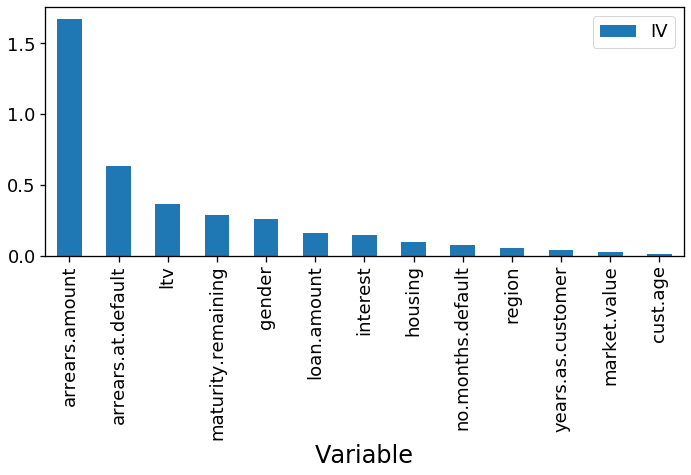

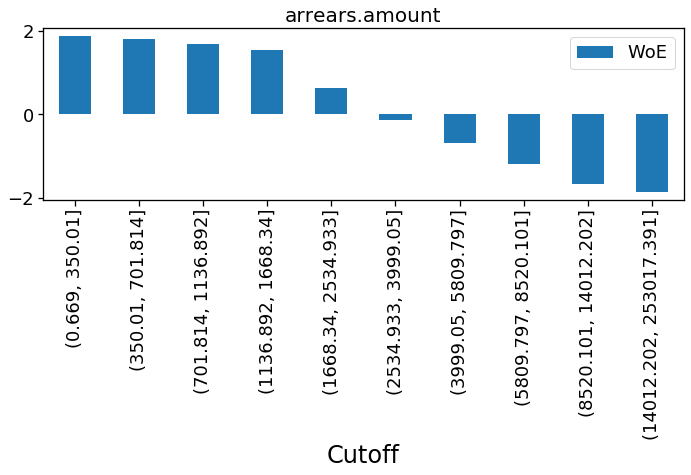

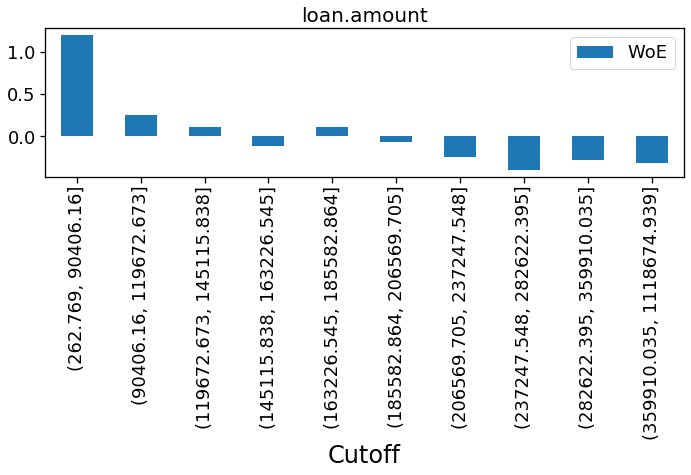

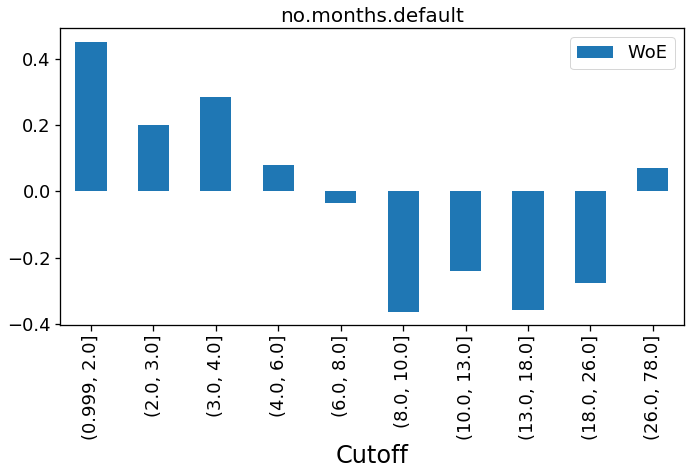

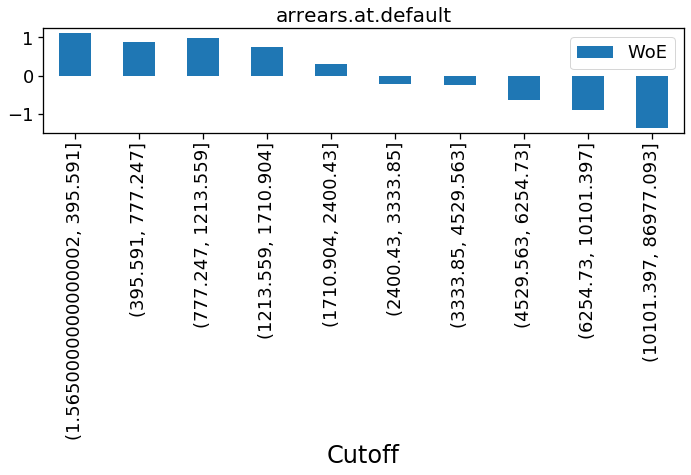

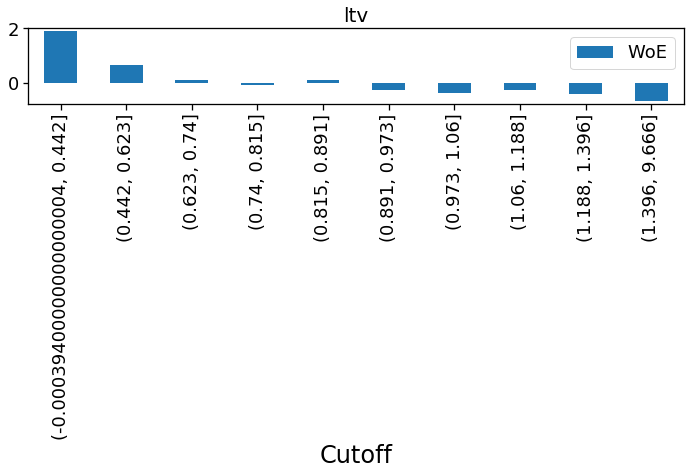

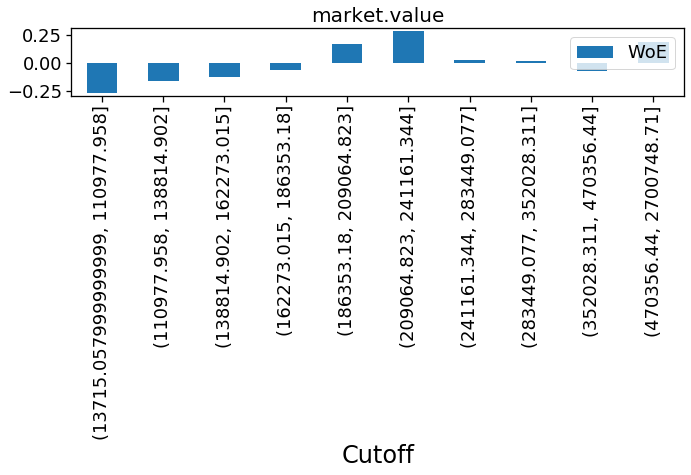

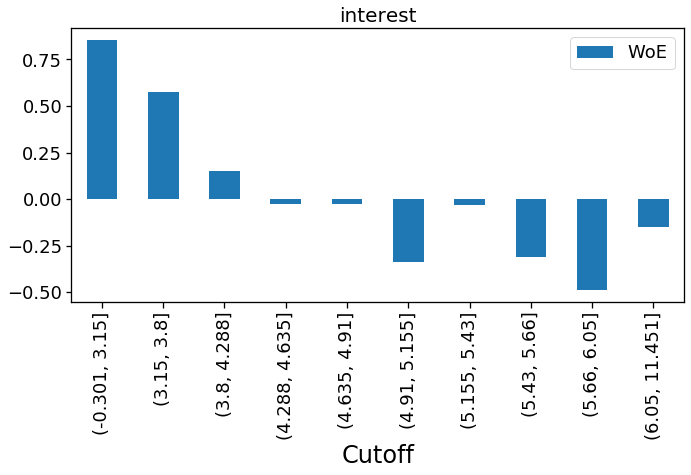

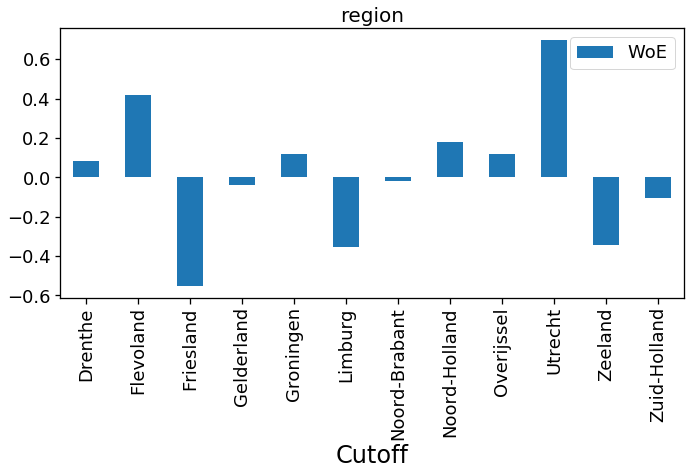

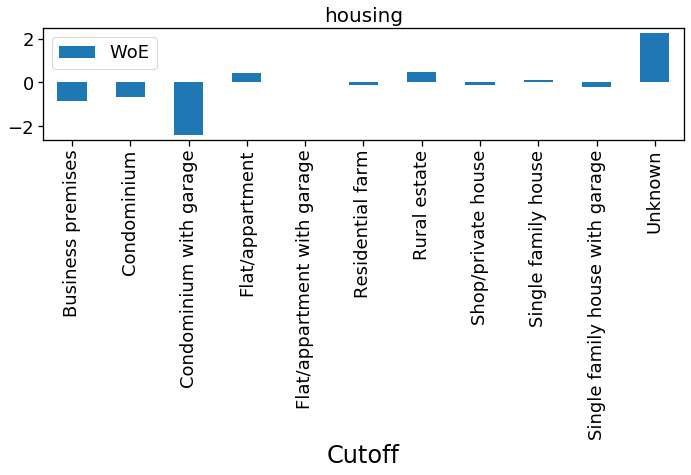

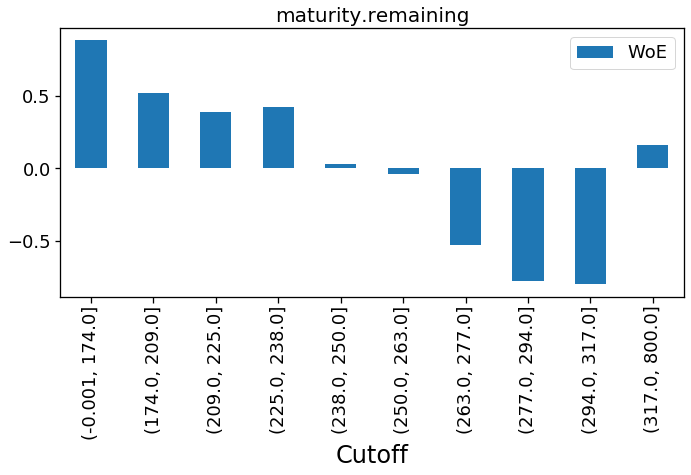

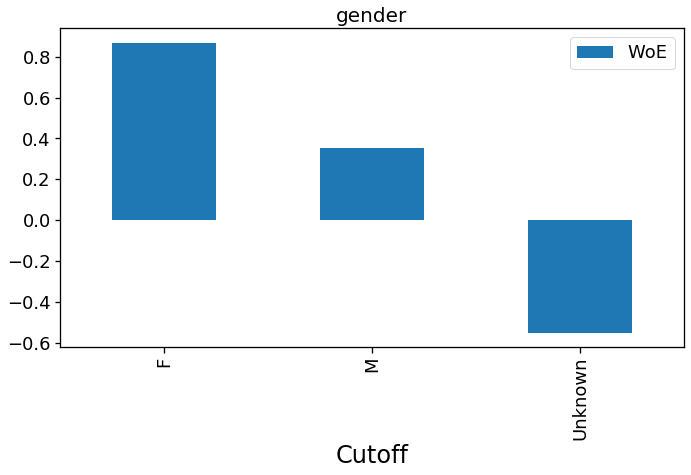

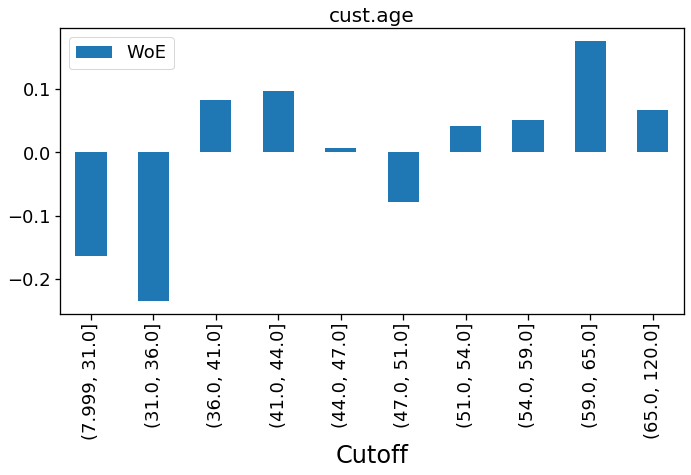

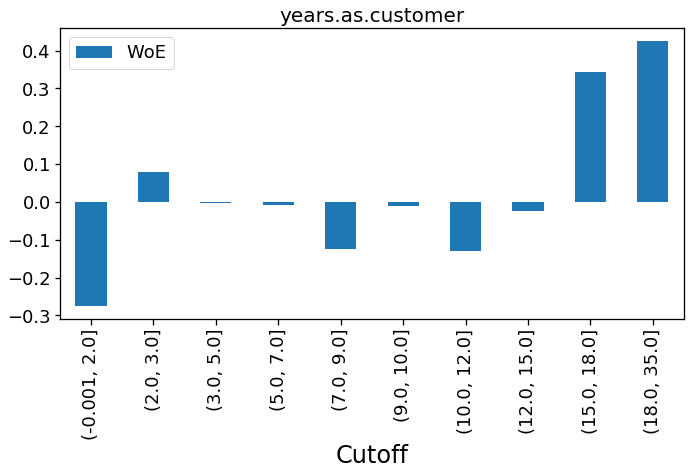

In [8]:
binned_df, bins, lbl = fc.binning(df, 'target', ['ID', 'period'], bins=10)
cols, d_lst, df_IV = fc.test_woe(binned_df, 'target', trend_visualize=True)
woe_df = fc.replace_woe(binned_df, d_lst, 'target')

#### apply functions on test set

In [9]:
df_test = df_test.drop(['ID', 'period'], axis=1)

In [10]:
binned_df_test = fc.binning_setbins(df_test, 'target', bins=bins, labels = lbl, correct_nan=True)
woe_df_test = fc.replace_woe(binned_df_test, d_lst, 'target')

### TODO: fix error

depending on the partition into X_train and X_test, the variables in X_test might contain values that do not fit into the binning found for X_train. For now, we will check that this does not happen too often and then simply drop the rows. However, this shld be properly dealt with in the future.

In [61]:
woe_df_test.isnull().sum()

woe_arrears.amount        0
woe_loan.amount           0
woe_no.months.default     0
woe_arrears.at.default    0
woe_ltv                   0
woe_market.value          0
woe_interest              0
woe_region                1
woe_housing               2
woe_maturity.remaining    0
woe_gender                0
woe_cust.age              0
woe_years.as.customer     0
target                    0
dtype: int64

In [63]:
woe_df_test = woe_df_test.dropna(axis=0)

In [64]:
X_train = woe_df.drop(['target'], axis=1)
X_test = woe_df_test.drop(['target'], axis=1)
y_train = woe_df['target']
y_test = woe_df_test['target']

### Fit Classifier and Predict Results

In [73]:
def GS_clf(penalty = ['l1', 'l2'], C = np.logspace(-7, 7, 29), cv=5):
    """
    Function that sets up the GridSearch model with crossvalidation.
    ---------
    Input:

    Returns:
        clf         object; to be fitted classifier
    
    """
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import LogisticRegression
    
    # set up logistic regression
    lr = LogisticRegression(C=1)
    
    # define grid of hyper parameters
    param_grid = [
            {'penalty' : ['l1', 'l2'],
            'C' : np.logspace(-7, 7, 29),
            'solver' : ['liblinear']},
        ]    
    
    # initialize classifier
    clf = GridSearchCV(lr, param_grid, scoring = 'roc_auc', n_jobs=-1, iid =True, refit = True, 
                           cv=cv, verbose=True, error_score='raise')
    
    return clf

clf = GS_clf(cv=2)  # this shld be higher when fitting for real
clf.fit(X_train, y_train)
pred_proba = clf.predict_proba(X_test)[:, 1]

# extract coefficients
coef = clf.best_estimator_.coef_[0]
intercept = clf.best_estimator_.intercept_[0]

Fitting 2 folds for each of 58 candidates, totalling 116 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    0.3s finished


### Scoring

In [71]:
def gini(y_true, y_pred):
    """
    Function computes the Gini coefficient between true labels and predicted probabilities.
    ---------
    Input:
        y_true      array; true labels
        y_pred      array; predicted probabilities       
    Returns:
        G_norm      scalar; Gini coefficient
    
    """
    # check for incorrect input
    assert y_true.shape == y_pred.shape
    n_samples = len(y_true)
    arr = np.array([y_true, y_pred]).transpose()
    
    # sort rows on prediction column (from smallest to largest)
    true_order = arr[arr[:,0].argsort()][:,0]
    pred_order = arr[arr[:,1].argsort()][:,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)    

    # get Gini coefficients (area between curves)
    G_true = 1-np.sum(np.diff(L_ones,1)*(np.roll(L_true,-1)+L_true)[0:-1])
    G_pred = 1-np.sum(np.diff(L_ones,1)*(np.roll(L_pred,-1)+L_pred)[0:-1])
    G_norm = G_pred / G_true # the closer to 1, the more accurate the model!
    
    return G_norm

print('Gini test: ' + str(gini(y_test, pred_proba)) )

Gini test: 0.7768935199685904


### Create Scorecard

In [74]:
def scorecard(d_lst, cols, coef, intercept, target_score=600, target_odds = 50, pts_double_odds=20):
    """
    Function that creates a scorecard based on the binning and corresponding WoE values and
    the result of the model fitting.  
    ---------
    Input:
        d_lst:      list; list with the bin statistics of which the WoE value is used
        cols:       pd index; list with variable names (omitting dependent variable)
        coef:       np array; list containing fitted regression coefficients
        intercept:  scalar; intercept of regression
    
    Returns:
        scorecard   dataframe; scorecard dataframe
    
    """
    # set up scorecard and basic scaling parameters
    scorecard = pd.DataFrame()
    factor = pts_double_odds / np.log(2)
    offset = target_score - factor * np.log(target_odds)
    
    # create list of Attributes with their corresponding WoE
    for i in range(len(cols)):
        df = pd.DataFrame({'Characteristic': cols[i] , 'Attribute': d_lst[i]['Cutoff'], 'WoE': d_lst[i]['WoE']})
        scorecard = pd.concat([scorecard, df], axis=0)
    
    # add to above list the score per attribute based on WoE and coefficients for logreg
    scorecard['Score'] = np.zeros(len(scorecard))
    for i in range(len(cols)):
        for j in range(0, len(scorecard)):
            if cols[i] == scorecard['Characteristic'].iloc[j]:
                scorecard['Score'].iloc[j] = np.round((coef[i]*scorecard['WoE'].iloc[j] + intercept/len(coef))*factor+ offset/len(coef),0)
    
    return scorecard

scorecard = scorecard(d_lst, cols, coef, intercept)
#scorecard.to_csv('scorecard.csv')

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


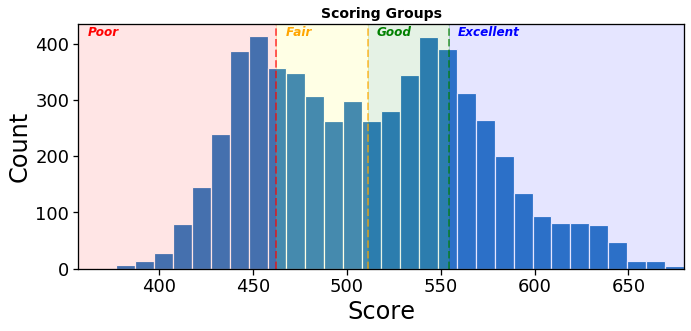

In [76]:
def score_data(woe_df, coef, intercept, target_score=600, target_odds = 50, pts_double_odds=20, visualize=True, savefig=False):
    """
    Function that scores a dataset based on the model. It is optional to output a distribution plot. 
    ---------
    Input:
        woe_df:     dataframe; WoE transformed df
        coef:       np array; list containing fitted regression coefficients
        intercept:  scalar; intercept of regression
    
    Returns:
        woe_df      dataframe; scorecard dataframe
    
    """
    import matplotlib.pyplot as plt
    
    # set up scoring parameters
    factor = pts_double_odds / np.log(2)
    offset = target_score - factor * np.log(target_odds)
    
    # compute score of each datapoint
    woe_df['Score'] = np.zeros(len(woe_df))
    for i in range (0,len(coef)):
        woe_df['Score'] += ((woe_df[woe_df.columns[i]] * coef[i])+ intercept/len(coef))*factor+ offset/len(coef)

    # compute log odds, odds and probs    
    woe_df['log odds'] = (woe_df['Score'] - offset) / factor
    woe_df['odds'] = np.exp(woe_df['log odds'])
    woe_df['probs'] = woe_df['odds'] / (woe_df['odds'] + 1)
    
    if visualize == True:
        # Add Scoring Groups to Plot
        plt.figure(figsize=(10, 5))
        count, score, _ = plt.hist(woe_df['Score'],
                 bins='auto',
                 edgecolor='white',
                 color = '#317DC2',
                 linewidth=1.2)
        
        plt.xlim(np.min(score),np.max(score))
        plt.title('Scoring Groups', fontweight="bold", fontsize=14)
        plt.xlabel('Score')
        plt.ylabel('Count')
        
        # Percentile Lines
        plt.axvline(np.percentile(woe_df['Score'],25), color='red', linestyle='dashed', linewidth=2, alpha=0.6)
        plt.axvline(np.percentile(woe_df['Score'],50), color='orange', linestyle='dashed', linewidth=2, alpha=0.6)
        plt.axvline(np.percentile(woe_df['Score'],75), color='green', linestyle='dashed', linewidth=2, alpha=0.6)
        
        # Text
        plt.text(np.min(score)+5, np.max(count), 'Poor', color='red', fontweight='bold', style='italic', fontsize=12)
        plt.text(np.percentile(woe_df['Score'],25)+5, np.max(count), 'Fair', color='orange', fontweight='bold', style='italic', fontsize=12)
        plt.text(np.percentile(woe_df['Score'],50)+5, np.max(count), 'Good', color='green', fontweight='bold', style='italic', fontsize=12)
        plt.text(np.percentile(woe_df['Score'],75)+5, np.max(count), 'Excellent', color='blue', fontweight='bold', style='italic', fontsize=12)
        
        # Shading between Percentiles
        plt.axvspan(np.min(score), np.percentile(woe_df['Score'],25), alpha=0.1, color='red')
        plt.axvspan(np.percentile(woe_df['Score'],25), np.percentile(woe_df['Score'],50), alpha=0.1, color='yellow')
        plt.axvspan(np.percentile(woe_df['Score'],50), np.percentile(woe_df['Score'],75), alpha=0.1, color='green')
        plt.axvspan(np.percentile(woe_df['Score'],75), np.max(score), alpha=0.1, color='blue');
        
        if savefig == True:
            plt.savefig('Score_distribution.pdf')

    return woe_df

score_data = fc.score_data(woe_df, coef, intercept, visualize=True)